In [3]:
# Imports
import math
import torch
import matplotlib

import numpy as np
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 14})

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

In [4]:
class LNNet(nn.Module):
  """
  A Linear Neural Net with one hidden layer
  """

  def __init__(self, in_dim, hid_dim, out_dim, scale_w1, scale_w2):
    """
    Initialize LNNet parameters

    Args:
      in_dim: int
        Input dimension
      out_dim: int
        Ouput dimension
      hid_dim: int
        Hidden dimension

    Returns:
      Nothing
    """
    super().__init__()
    self.in_hid = nn.Linear(in_dim, hid_dim, bias=False)
    nn.init.normal_(self.in_hid.weight, mean=0.0, std=scale_w1)

    self.hid_out = nn.Linear(hid_dim, out_dim, bias=False)
    nn.init.normal_(self.hid_out.weight, mean=0.0, std=scale_w2)

  def forward(self, x):
    """
    Forward pass of LNNet

    Args:
      x: torch.Tensor
        Input tensor

    Returns:
      hid: torch.Tensor
        Hidden layer activity
      out: torch.Tensor
        Output/Prediction
    """
    hid = F.relu(self.in_hid(x))  # Hidden activity
    # out = F.tanh(self.hid_out(hid))  # Output (prediction)
    out = self.hid_out(hid)  # Output (prediction)
    return out, hid

def initializer_(model, scale_ws):
  """
  In-place Re-initialization of weights

  Args:
    model: torch.nn.Module
      PyTorch neural net model
    gamma: float
      Initialization scale

  Returns:
    Nothing
  """
  for w_i, weight in enumerate(model.parameters()):
    n_out, n_in = weight.shape
    # sigma = gamma / math.sqrt(n_in + n_out)
    nn.init.normal_(weight, mean=0.0, std=scale_ws[w_i])

In [5]:
def train(model, inputs, targets, n_epochs, lr):
  """
  Training function

  Args:
    model: torch nn.Module
      The neural network
    inputs: torch.Tensor
      Features (input) with shape `[batch_size, input_dim]`
    targets: torch.Tensor
      Targets (labels) with shape `[batch_size, output_dim]`
    n_epochs: int
      Number of training epochs (iterations)
    lr: float
      Learning rate

  Returns:
    losses: np.ndarray
      Record (evolution) of training loss
  """
  losses = np.zeros(n_epochs)  # Loss records
  weight_rel_changes = [np.zeros(n_epochs), np.zeros(n_epochs)]  # Relative changes of weights in input-hidden layer and hidden-output layer

  optimizer = optim.SGD(model.parameters(), lr=lr)
  criterion = nn.MSELoss()

  init_weight_norms = []
  for weight in dlnn_model.parameters():
    init_weight_norms.append(torch.linalg.norm(weight))

  for i in range(n_epochs):
    optimizer.zero_grad()
    predictions, hiddens = model(inputs)
    loss = criterion(predictions, targets)
    loss.backward()
    optimizer.step()

    # Logging (recordings)
    losses[i] = loss.item()
    # Relative changes in weights
    for w_i, weight in enumerate(model.parameters()):
      weight_rel_changes[w_i][i] = (torch.linalg.norm(weight) - init_weight_norms[w_i]) / init_weight_norms[w_i]

  return losses, weight_rel_changes

In [6]:
# @title Generate data
def create_dataset(x1, x2, y, n_repeats=50, noise_lev = 0.1):
  # Repeat the numbers from x1, x2, and y n_repeats times
  x1 = np.repeat(x1, n_repeats)
  x2 = np.repeat(x2, n_repeats)
  y =  np.repeat(y,  n_repeats)

  # Add noise to data points just to have some data variety
  x1 = x1 + np.random.randn(x1.shape[0]) * noise_lev
  x2 = x2 + np.random.randn(x2.shape[0]) * noise_lev

  # Shuffle
  index_shuffle = np.arange(x1.shape[0])
  np.random.shuffle(index_shuffle)

  x1 = x1.astype(np.float32)
  x2 = x2.astype(np.float32)
  y  = y.astype(np.float32)

  x1 = x1[index_shuffle]
  x2 = x2[index_shuffle]
  y  = y [index_shuffle]

  # Convert data to tensors
  x1_torch = torch.from_numpy(x1).clone().view(-1, 1)
  x2_torch = torch.from_numpy(x2).clone().view(-1, 1)
  y_torch = torch.from_numpy(y).clone().view(-1, 1)

  # Combine X1 and X2
  X = torch.hstack([x1_torch, x2_torch])


  # Split into training and testing
  n_samples = X.shape[0]
  split_index = int(np.ceil(n_samples * 0.8))

  X_train = X[:split_index, :]
  y_train = y_torch[:split_index]
  X_test = X[split_index:, :]
  y_test = y_torch[split_index:]

  return X_train, y_train, X_test, y_test

/var/folders/6t/ypd5fzvx63q7qrx954wb8hhr0000gn/T/ipykernel_48361/1037549206.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400265103/work/torch/csrc/utils/tensor_new.cpp:264.)
  X = torch.tensor([x1, x2]).T


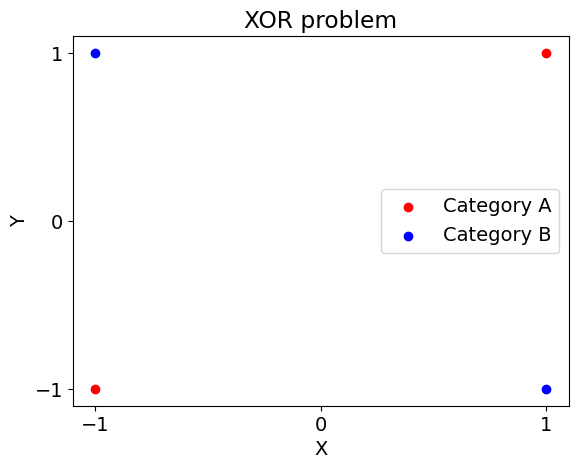

In [7]:
x1 = np.array ([-1., -1., 1., 1.], dtype = np.float32)
x2 = np.array ([-1., 1., -1., 1.], dtype = np.float32)
y  = np.array ([-1., 1., 1., -1.],dtype = np.float32)

plt.scatter(x1[y == -1.], x2[y == -1.], c = 'r', label = 'Category A')
plt.scatter(x1[y == 1.], x2[y == 1.], c = 'b', label = 'Category B')
plt.xlabel('X')
plt.ylabel('Y')
plt.xticks([-1, 0, 1])
plt.yticks([-1, 0, 1])
plt.legend()
plt.title('XOR problem')

# X_train, y_train, X_test, y_test = create_dataset(x1, x2, y, n_repeats=50)
X = torch.tensor([x1, x2]).T
y = torch.tensor(y).unsqueeze(1)

# plt.savefig("x-or problem.svg")

In [ ]:
n_runs = 20
n_epochs = 5000  # Number of epochs
dim_input = 2  # Input dimension = (X, Y)
dim_hidden = 500  # Hidden neurons
dim_output = 1  # Output dimension = Category A or B (0, 1)

lr = 2e-3  # Learning rate
w1_inits = [0.001,0.01,0.1,0.5] # Initialization scale
w2_init = 1/dim_hidden

models = []
losses = np.zeros((len(w1_inits), n_runs, n_epochs))
w1_rel_changes = np.zeros((len(w1_inits), n_runs, n_epochs))
w2_rel_changes = np.zeros((len(w1_inits), n_runs, n_epochs))

# Training
for w_i, w1_init in enumerate(w1_inits):
  for r_i in range(n_runs):
    # Model instantiation
    dlnn_model = LNNet(dim_input, dim_hidden, dim_output, w1_init, w2_init)
    # Weights re-initialization
    # initializer_(dlnn_model, [w1_init, w2_init])
    loss_per_run, weight_rel_changes_per_run = train(dlnn_model, X, y, n_epochs=n_epochs, lr=lr)
    losses[w_i, r_i, :] = loss_per_run
    w1_rel_changes[w_i, r_i, :] = weight_rel_changes_per_run[0]
    w2_rel_changes[w_i, r_i, :] = weight_rel_changes_per_run[1]

  models.append(dlnn_model)

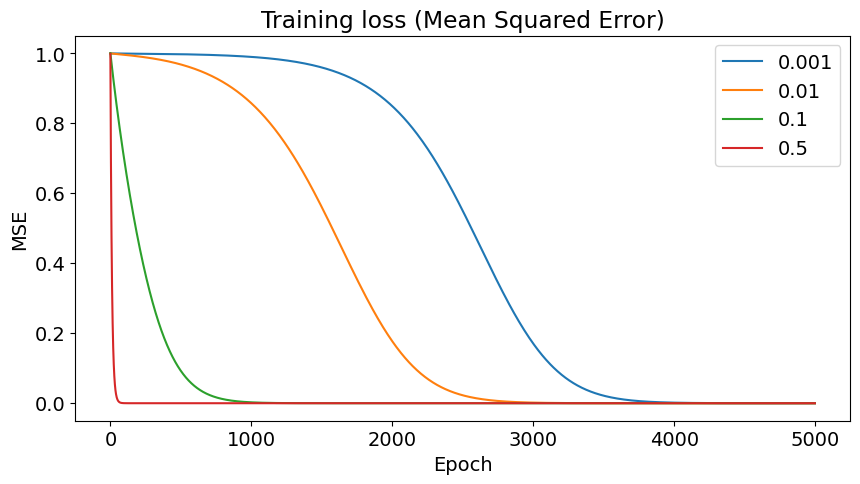

In [ ]:
# Plotting losses
def plot_loss(loss_array,
              w1_scales,
              title="Training loss (Mean Squared Error)",
              c="r"):
  """
  Plot loss function

  Args:
    c: string
      Specifies plot color
    title: string
      Specifies plot title
    loss_array: np.ndarray
      Log of MSE loss per epoch

  Returns:
    Nothing
  """
  plt.figure(figsize=(10, 5))
  for w_i, w1 in enumerate(w1_scales):
    plt.plot(np.mean(loss_array[w_i, :, :], 0), label=w1)
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title(title)
  plt.legend()
  plt.show()

plot_loss(losses, w1_inits)

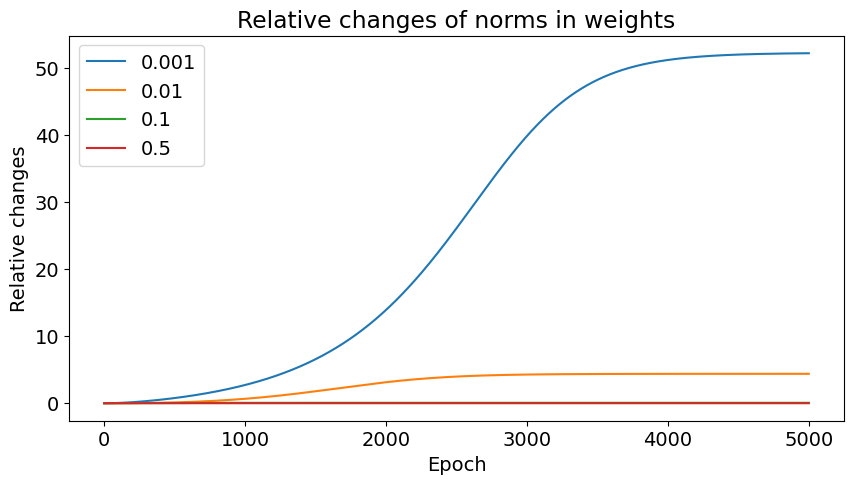

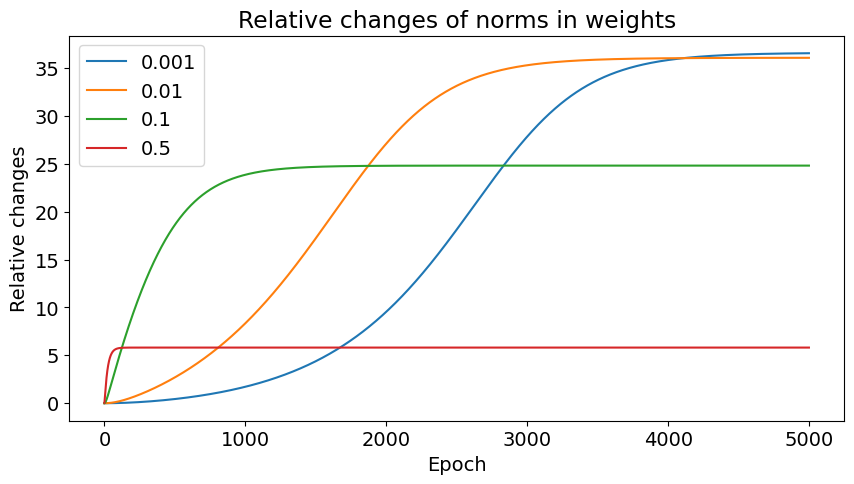

In [ ]:
# Plotting relative changes of norms in wieghts
def plot_rel_changes(rel_change_array,
              w1_scales,
              title="Relative changes of norms in weights",
              c="r"):
  """
  Plot loss function

  Args:
    c: string
      Specifies plot color
    title: string
      Specifies plot title
    loss_array: np.ndarray
      Log of MSE loss per epoch

  Returns:
    Nothing
  """
  plt.figure(figsize=(10, 5))
  for w_i, w1 in enumerate(w1_scales):
    plt.plot(np.mean(rel_change_array[w_i, :, :], 0), label=w1)
    plt.xlabel("Epoch")
    plt.ylabel("Relative changes")
    plt.title(title)
  plt.legend()
  plt.show()

plot_rel_changes(w1_rel_changes, w1_inits)
plot_rel_changes(w2_rel_changes, w1_inits)

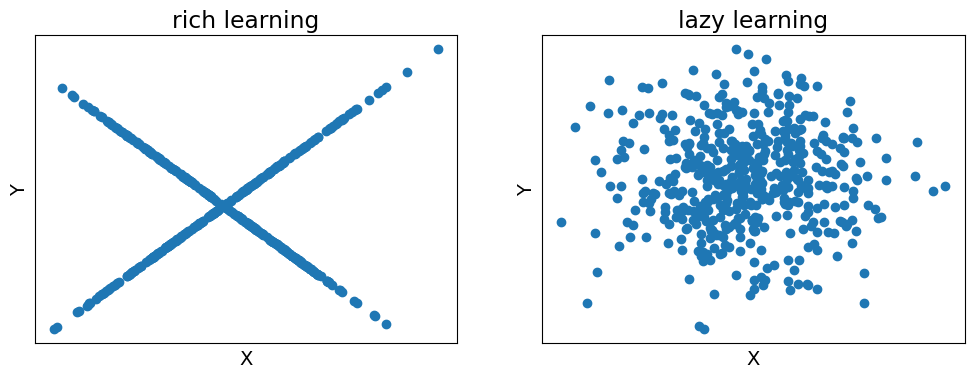

In [ ]:
rich_lazy_models = [models[0], models[-1]]
model_titles = ['rich', 'lazy']

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
for a_i, axis in enumerate(axes):
  model = rich_lazy_models[a_i]
  for name, param in model.named_parameters():
    if name == 'in_hid.weight':
      in_hid = param.detach().numpy()
      axis.scatter(in_hid[:, 0], in_hid[:, 1])
      axis.set_xticks([])
      axis.set_yticks([])
      axis.set_xlabel('X')
      axis.set_ylabel('Y')
      axis.set_title(f'{model_titles[a_i]} learning')

# plt.savefig("rich_lazy_learning_trained.svg")

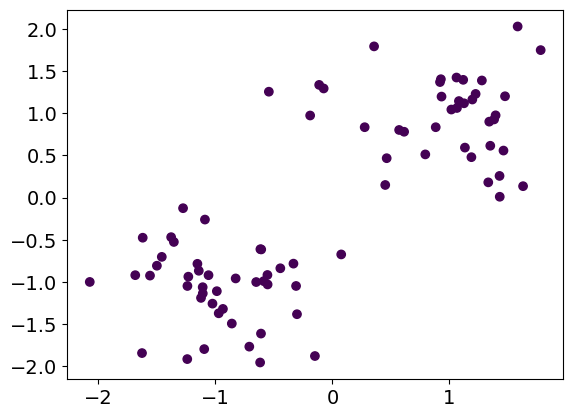

In [ ]:
bias_models = []
for model in models:
  bias_models.append(copy.deepcopy(model))

bias_x1 = np.array ([1., -1.], dtype = np.float32)
bias_x2 = np.array ([1., -1.], dtype = np.float32)
bias_y  = np.array ([-1., -1.],dtype = np.float32)
# bias_x1 = np.array ([1.], dtype = np.float32)
# bias_x2 = np.array ([1.], dtype = np.float32)
# bias_y  = np.array ([-1.],dtype = np.float32)
bias_X_train, bias_y_train, bias_X_test, bias_y_test = create_dataset(bias_x1, bias_x2, bias_y, n_repeats=50, noise_lev=0.5)

plt.scatter(bias_X_train[:, 0], bias_X_train[:, 1], c = bias_y_train)

In [ ]:
n_runs = 1
n_epochs = 5000  # Number of epochs

lr = 2e-3  # Learning rate

bias_losses = np.zeros((2, n_runs, n_epochs))
# Training
for m_i, bias_model in enumerate([bias_models[0], bias_models[-1]]):
  for r_i in range(n_runs):
    bias_loss_per_run, _ = train(bias_model, bias_X_train, bias_y_train, n_epochs=n_epochs, lr=lr)
    bias_losses[m_i, r_i, :] = bias_loss_per_run

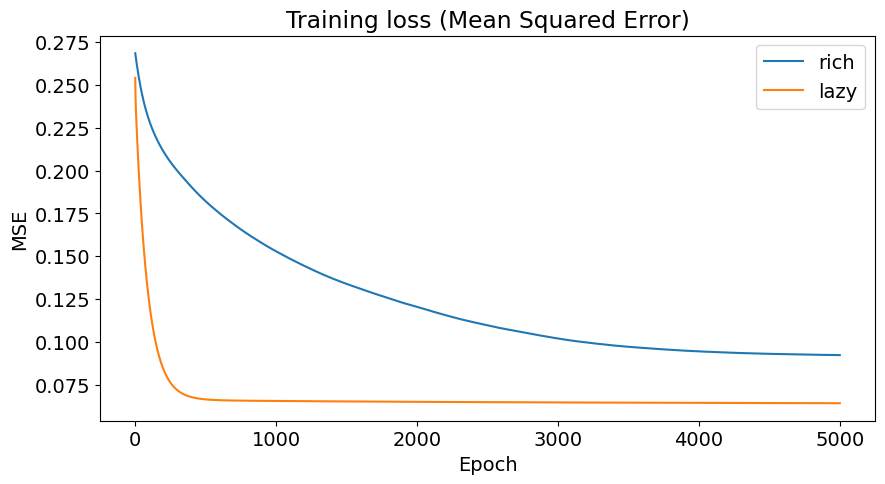

In [ ]:
# Plotting losses
plot_loss(bias_losses, w1_scales=['rich', 'lazy'])

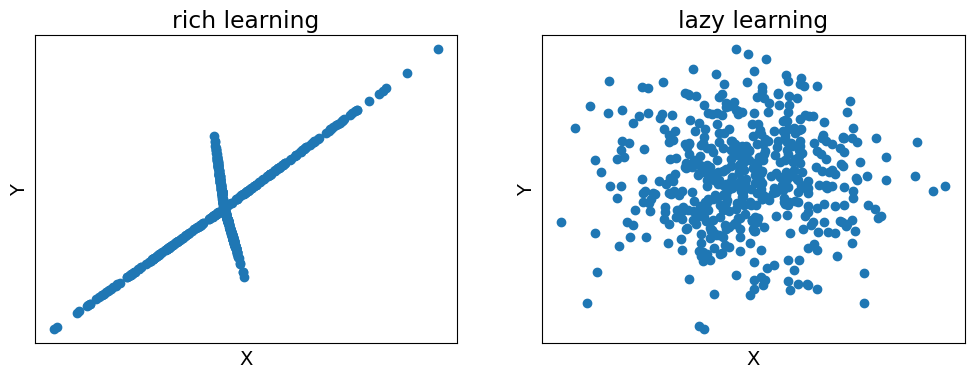

In [ ]:
bias_rich_lazy_models = [bias_models[0], bias_models[-1]]
model_titles = ['rich', 'lazy']

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
for a_i, axis in enumerate(axes):
  model = bias_rich_lazy_models[a_i]
  for name, param in model.named_parameters():
    if name == 'in_hid.weight':
      in_hid = param.detach().numpy()
      axis.scatter(in_hid[:, 0], in_hid[:, 1])
      axis.set_xticks([])
      axis.set_yticks([])
      axis.set_xlabel('X')
      axis.set_ylabel('Y')
      axis.set_title(f'{model_titles[a_i]} learning')

# plt.savefig("rich_lazy_learning_bev_bias.svg")

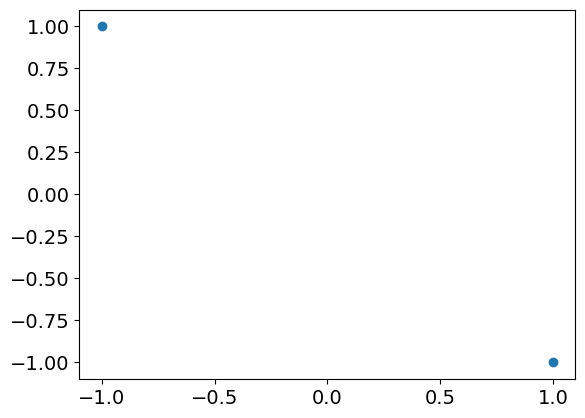

In [ ]:
replay_bias_models = []
for bias_model in bias_models:
  replay_bias_models.append(copy.deepcopy(bias_model))

replay_bias_x1 = np.array ([-1., 1.], dtype = np.float32)
replay_bias_x2 = np.array ([1., -1.], dtype = np.float32)
replay_bias_y  = np.array ([1., 1.],dtype = np.float32)

# replay_bias_x1 = np.array ([-1.], dtype = np.float32)
# replay_bias_x2 = np.array ([-1.], dtype = np.float32)
# replay_bias_y  = np.array ([-1.],dtype = np.float32)

replay_bias_X = torch.tensor([replay_bias_x1, replay_bias_x2]).T
replay_bias_y = torch.tensor(replay_bias_y).unsqueeze(1)
plt.scatter(replay_bias_X[:, 0], replay_bias_X[:, 1])

# replay_bias_X_train, replay_bias_y_train, _, _ = create_dataset(replay_bias_x1, replay_bias_x2, bias_y, n_repeats=50, noise_lev=0)
# plt.scatter(replay_bias_X_train[:, 0], replay_bias_X_train[:, 1], c = replay_bias_y_train)

In [ ]:
n_runs = 1
n_epochs = 5000  # Number of epochs

lr = 2e-3  # Learning rate

replay_bias_losses = np.zeros((2, n_runs, n_epochs))
# Training
for m_i, replay_bias_model in enumerate([replay_bias_models[0], replay_bias_models[-1]]):
  for r_i in range(n_runs):
    replay_bias_loss_per_run, _ = train(replay_bias_model, replay_bias_X, replay_bias_y, n_epochs=n_epochs, lr=lr)
    replay_bias_losses[m_i, r_i, :] = replay_bias_loss_per_run

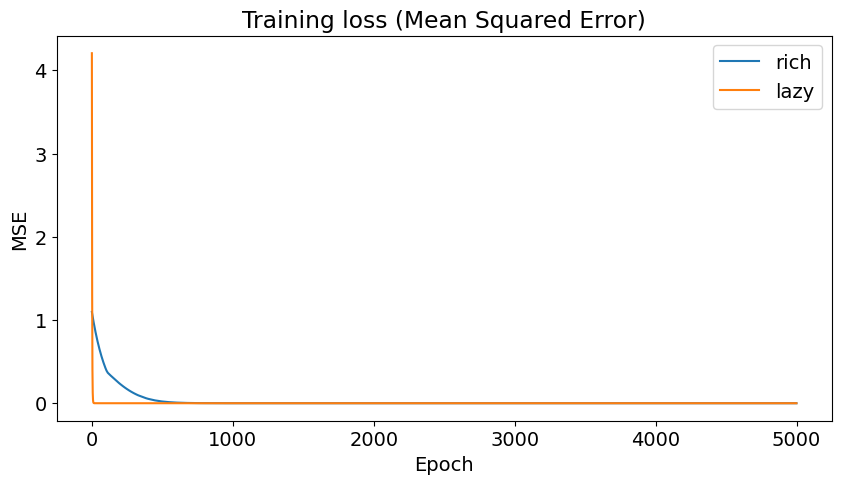

In [ ]:
# Plotting losses
plot_loss(replay_bias_losses, w1_scales=['rich', 'lazy'])

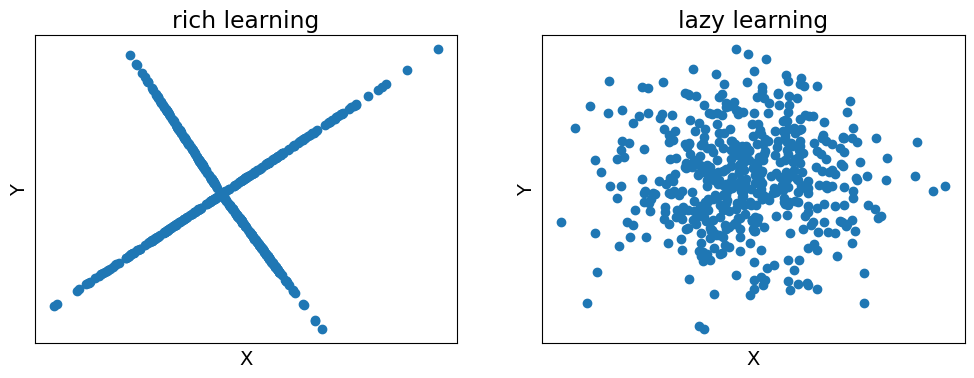

In [ ]:
replay_bias_rich_lazy_models = [replay_bias_models[0], replay_bias_models[-1]]
model_titles = ['rich', 'lazy']

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
for a_i, axis in enumerate(axes):
  model = replay_bias_rich_lazy_models[a_i]
  for name, param in model.named_parameters():
    if name == 'in_hid.weight':
      in_hid = param.detach().numpy()
      axis.scatter(in_hid[:, 0], in_hid[:, 1])
      axis.set_xticks([])
      axis.set_yticks([])
      axis.set_xlabel('X')
      axis.set_ylabel('Y')
      axis.set_title(f'{model_titles[a_i]} learning')

# plt.savefig("rich_lazy_learning_after_replay_bias.svg")